# Bloem transormer tutorial
> Pretty much a verbatim copy of https://peterbloem.nl/blog/transformers


In [1]:
BATCH_SIZE = 32
N_TOKENS = 100

In [2]:
pip install nltk

/home/phil/miniconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Get dataset

In [4]:
# I don't like how they just assume x is a tensor of size (b, t, k)
# Instead, I'm going to use word2vec embeddings for actual phrases
# I will use a readily available word2vec model from gensim, a readily available tokenizer from nltk, and a readily available dataset from sklearn

# from gensim.models import KeyedVectors
from gensim.downloader import load
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.datasets import fetch_20newsgroups

# Get training data
raw_data = fetch_20newsgroups(
    subset='train',
    remove=('headers', 'footers', 'quotes')
)

# Tokenize - remove punctuation, lowercase, etc.
word2vec = load('word2vec-google-news-300')
data_tokens = [word_tokenize(doc) for doc in raw_data.data]


# Get word2vec embeddings for each token
data = []
for doc in data_tokens:
    doc_vecs = []
    for token in doc:
        try:
            doc_vecs.append(word2vec[token])
        except KeyError:
            pass
    data.append(doc_vecs)

/home/phil/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to /home/phil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Make X into an array of tensors of size (100, 300) where n is the number of tokens in the document

X = []
for doc in data:
    while len(doc) > N_TOKENS:
        X.append(torch.tensor(doc[:N_TOKENS]))
        doc = doc[100:]
    
    # Final doc must be padded
    doc += [[0]*300]*(N_TOKENS-len(doc))
    X.append(torch.tensor(doc))

X = torch.stack(X)
print(X.shape)

/tmp/ipykernel_483574/1465266012.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  X.append(torch.tensor(doc))


torch.Size([26804, 100, 300])


## Basic attention

In [6]:
b = BATCH_SIZE
t = N_TOKENS
k = 300 # word2vec embedding size

In [7]:
_rw = torch.bmm(X, X.transpose(1, 2)) # Tutorial version
raw_weights = X @ X.transpose(1, 2) # Minibatch remains in dim 0: batched matrix multiplication is automatic
assert torch.allclose(_rw, raw_weights)

weights = F.softmax(raw_weights, dim=2) # Softmax goes over tokens

y = weights @ X # y is a weighted sum of the tokens in each document

print(y.shape)

torch.Size([26804, 100, 300])


In [8]:
# Now let's do heldout token prediction

# Dataset
X_heldout = []
y_heldout = []
idx_heldout = []
for i in range(len(X)):
    # Zero out random token
    idx = np.random.randint(0, N_TOKENS)

    # Masked token in X_heldout
    X_heldout.append(X[i].clone())
    X_heldout[-1][idx] = 0

    # Correct token in y_heldout
    y_heldout.append(X[i][idx])

    # Index of masked token
    idx_heldout.append(idx)

X_heldout = torch.stack(X_heldout)
y_heldout = torch.stack(y_heldout)

In [19]:
PRINT_INTERVAL = 1000

# Model
class Bloem(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(300, 300)
        self.linear2 = nn.Linear(300, 300)
        
    def forward(self, x):
        # Use attention weights
        weights = F.softmax(x @ x.transpose(1, 2) / 300 ** 0.5, dim=2)
        y1 = weights @ x
        y2 = y1 @ self.linear1.weight + self.linear1.bias
        y2 = F.relu(y2)
        r3 = y2 @ self.linear2.weight + self.linear2.bias
        return r3
    
model = Bloem()

# Loss
loss_fn = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss counter
losses = []

# Training loop
for epoch in range(5):
    for i in range(len(X)):
        # Forward pass
        y_pred = model(X_heldout[i:i+1])
        
        # Compute loss
        pred_token = y_pred[:, idx_heldout[i]]
        loss = loss_fn(pred_token, y_heldout[i])
        losses.append(loss.item())
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()

        if i % PRINT_INTERVAL == 0:
            print(f'Epoch {epoch+1} loss: {np.mean(losses[-PRINT_INTERVAL:])}')
        
    print(f'Epoch {epoch+1} loss: {loss.item()}')

Epoch 1 loss: 0.0014282956253737211
Epoch 1 loss: 0.013606896942499589
Epoch 1 loss: 0.015324562204550602
Epoch 1 loss: 0.014252761399256996
Epoch 1 loss: 0.015907162986812183
Epoch 1 loss: 0.013166080409486313
Epoch 1 loss: 0.013762694322100288
Epoch 1 loss: 0.013106143376873661
Epoch 1 loss: 0.014741013009632297
Epoch 1 loss: 0.014564138512811041
Epoch 1 loss: 0.013850829072969646
Epoch 1 loss: 0.013431218494581117
Epoch 1 loss: 0.0144240570657239
Epoch 1 loss: 0.013789801016107958
Epoch 1 loss: 0.01444808213041324
Epoch 1 loss: 0.013381376307042956
Epoch 1 loss: 0.013212667077452351
Epoch 1 loss: 0.014224552552594106
Epoch 1 loss: 0.014582807442711782
Epoch 1 loss: 0.013611658018595336
Epoch 1 loss: 0.014607525937986794
Epoch 1 loss: 0.012611919774448324
Epoch 1 loss: 0.011784655688326894
Epoch 1 loss: 0.013840922284740372
Epoch 1 loss: 0.014229247126681003
Epoch 1 loss: 0.013517095187628001
Epoch 1 loss: 0.014157206708827289
Epoch 1 loss: 0.000821079418528825
Epoch 2 loss: 0.014161

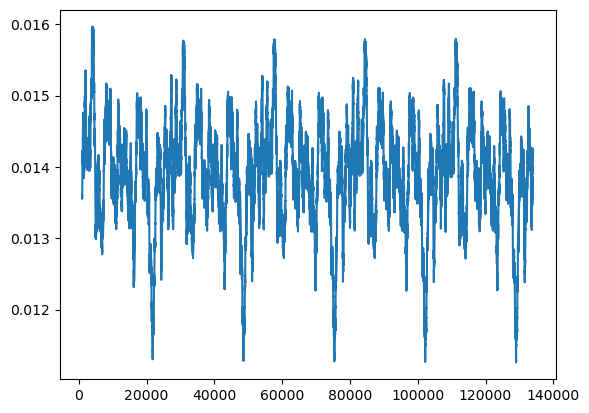

In [21]:
# Plot loss using a rolling average

plt.plot(pd.Series(losses).rolling(1000).mean())

## Bloem multihead attention

In [ ]:
# Self-attention first

class SelfAttention(nn.Module):
    def __init__(self, k, n_heads=4, mask=False):
        super().__init__()

        assert k % n_heads == 0

        self.k = k
        self.n_heads = n_heads
        self.mask = mask
        
        self.tokeys = nn.Linear(k, k, bias=False)
        self.toqueries = nn.Linear(k, k, bias=False)
        self.tovalues = nn.Linear(k, k, bias=False)

        self.unifyheads = nn.Linear(k, k)
    
    def forward(self, x):
        b, t, k = x.size() # Batch size, #tokens, embedding size
        h = self.n_heads # Number of heads
        s = k // h # Size of each head

        # Compute queries, keys, and values as 4-D tensors
        queries = self.toqueries(x).view(b, t, h, s)
        keys = self.tokeys(x).view(b, t, h, s)
        values = self.tovalues(x).view(b, t, h, s)

        # Reshape to 3-D tensors
        queries = queries.transpose(1, 2).contiguous().view(b*h, t, s)
        keys = keys.transpose(1, 2).contiguous().view(b*h, t, s)
        values = values.transpose(1, 2).contiguous().view(b*h, t, s)

        # Compute dot products
        dot = F.softmax(
            queries @ keys.transpose(1, 2) / (k ** 0.5),
            dim=2
        ) # (b*h, t, t)

        return (dot @ values).view(b, h, t, s)

: 

: 